c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


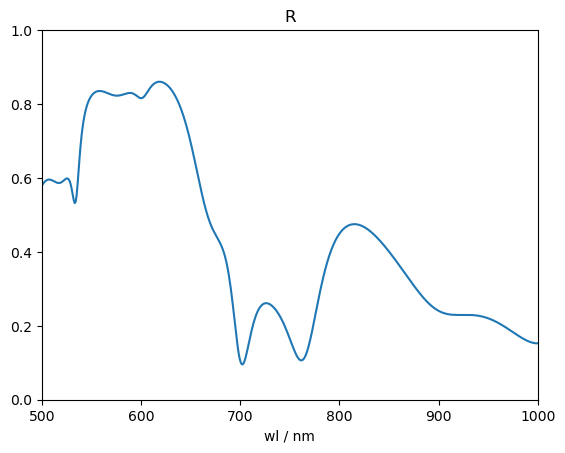

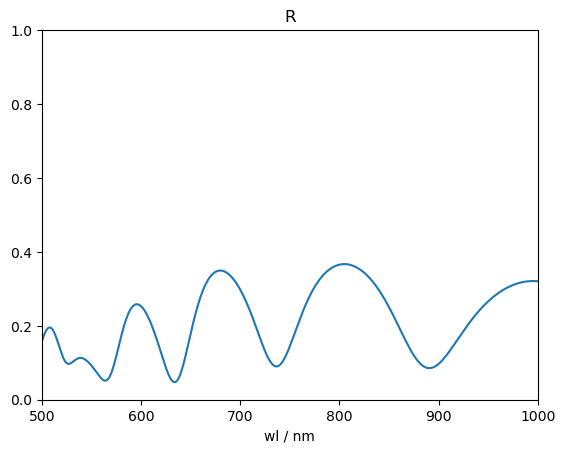

In [1]:
import sys
sys.path.append('./../../designer/script/')
from gets.get_spectrum import get_spectrum_simple
from design import DesignSimple
from film import FilmSimple
from spectrum import SpectrumSimple
from utils.plot_spectrum import plot_spectrum
from utils.load_designs import load_designs_single_spec as load_designs
import numpy as np
import copy
from utils.loss import calculate_RMS
import matplotlib.pyplot as plt

# Initialize: config for TML
WLS = np.linspace(500, 1000, 500)
INC_ANG = 60.
wl = 750. # wl used for calculating OT

def plot_film(f: FilmSimple):
    f.add_spec_param(INC_ANG, WLS)
    spec_target = f.get_spec()
    spec_target.calculate() # compile cuda kernel func
    plot_spectrum(spec_target)

np.random.seed(1)
f_target_30layers = FilmSimple("SiO2", "TiO2", "SiO2", np.random.random(30) * 100) # target film
plot_film(f_target_30layers)

np.random.seed(1)
f_target_4layers = FilmSimple("SiO2", "TiO2", "SiO2", np.random.random(4) * 750) # target film
plot_film(f_target_4layers)

In [10]:
# Load trained films data and construct Design objects

load_file_dir_SiO2_target_30layers = './../raw_design_result/50iters_0to2OT_200run_SiO2_target30layers/'
load_file_dir_TiO2_target_30layers = './../raw_design_result/50iters_0to2OT_200run_TiO2_target30layers/'
load_file_dir_SiO2_target_4layers = './../raw_design_result/50iters_0to2OT_200run_SiO2_target4layers/'
load_file_dir_TiO2_target_4layers = './../raw_design_result/50iters_0to2OT_200run_TiO2_target4layers/'

save_fig_dir_SiO2_target_30layers = './figs/50iters_0to2OT_200run_SiO2_target30layers/'
save_fig_dir_TiO2_target_30layers = './figs/50iters_0to2OT_200run_TiO2_target30layers/'
save_fig_dir_SiO2_target_4layers = './figs/50iters_0to2OT_200run_SiO2_target4layers/'
save_fig_dir_TiO2_target_4layers = './figs/50iters_0to2OT_200run_TiO2_target4layers/'


designs_SiO2_target30 = load_designs(load_file_dir_SiO2_target_30layers, f_target_30layers, n_A='SiO2', n_B='TiO2', n_sub='SiO2')
designs_TiO2_target30 = load_designs(load_file_dir_TiO2_target_30layers, f_target_30layers, n_A='TiO2', n_B='SiO2', n_sub='SiO2')
designs_SiO2_target4 = load_designs(load_file_dir_SiO2_target_4layers, f_target_4layers, n_A='SiO2', n_B='TiO2', n_sub='SiO2')
designs_TiO2_target4 = load_designs(load_file_dir_TiO2_target_4layers, f_target_4layers, n_A='TiO2', n_B='SiO2', n_sub='SiO2')

Trained film should not have zero geometric thickness (run 0)
Trained film should not have zero geometric thickness (run 0)
Trained film should not have zero geometric thickness (run 0)
Trained film should not have zero geometric thickness (run 0)


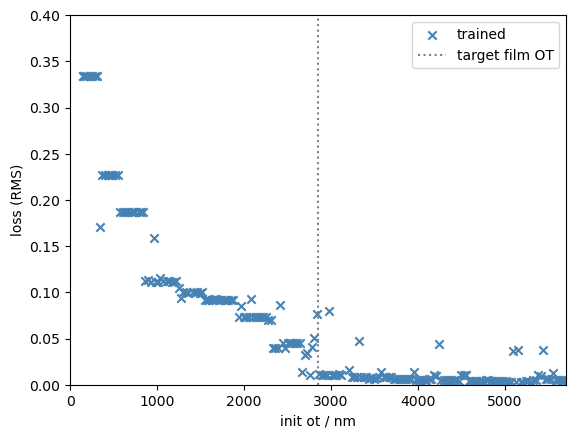

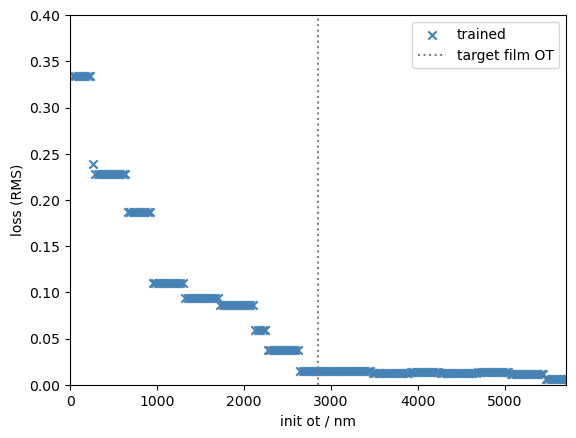

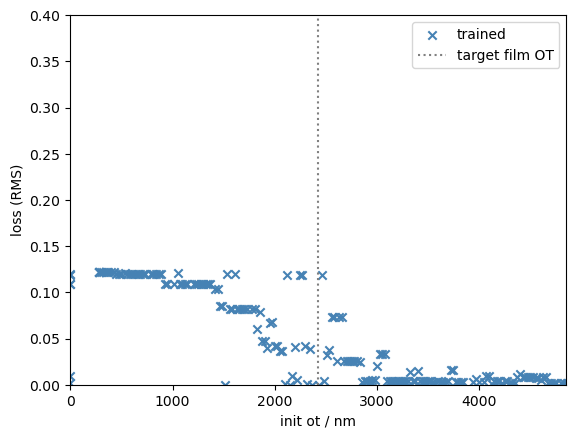

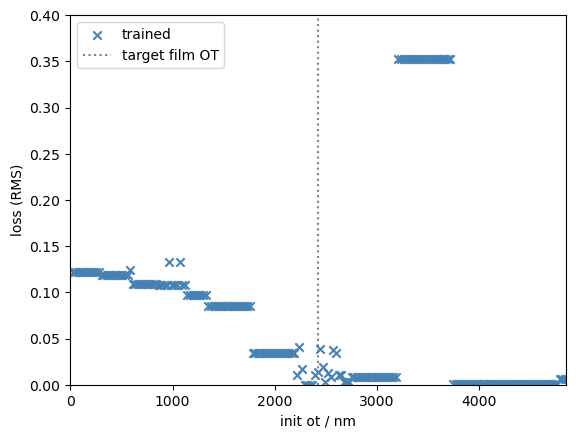

In [10]:
def plot(design_list: list[DesignSimple], x='wrt init ot'):
    target_ot = design_list[0].get_target_ot(wl)
    target_thickness = design_list[0].get_target_gt()
             
    fig, ax = plt.subplots(1, 1)

    if x == 'wrt init ot':
        for design in design_list:
            ax.scatter(design.get_init_ot(wl), design.loss, c='steelblue', marker='x')
        # scatter the first dot for the legend
        ax.scatter(design.get_init_ot(wl), design.loss, c='steelblue', marker='x', label='trained')
        ax.plot([target_ot, target_ot], [0, 1], label='target film OT', c='gray', ls=':')

        ax.set_xlabel('init ot / nm')
        ax.set_xlim(0, target_ot * 2)

    elif x == 'wrt final ot':
        for design in design_list:
            ax.scatter(design.get_current_ot(wl), design.loss, c='steelblue', marker='x')
        # scatter the first dot for the legend
        ax.scatter(design.get_current_ot(wl), design.loss, c='steelblue', marker='x', label='trained')
        ax.plot([target_ot, target_ot], [0, 1], label='target film OT', c='gray', ls=':')
        
        ax.set_xlabel('final ot / nm')
        ax.set_xlim(0, target_ot * 2)

    elif x == 'wrt init gt': # geometrical thickness
        for design in design_list:
            ax.scatter(design.get_init_gt(), design.loss, c='steelblue', marker='x')
        # scatter the first dot for the legend
        ax.scatter(design.get_init_gt(), design.loss, c='steelblue', marker='x', label='trained')
        ax.plot([target_thickness, target_thickness], [0, 1], label='target film GT', c='gray', ls=':')
        
        ax.set_xlabel('init gt / nm')
        ax.set_xlim(0, target_thickness * 3)

    ax.legend()
    ax.set_ylabel('loss (RMS)')
    ax.set_ylim(0, 0.4) # set lower bound of y to zero



    return fig




plot(designs_SiO2_target30[1:], 'wrt init ot').savefig(save_fig_dir_SiO2_target_30layers + 'loss-initial_ot.png', dpi=300) # time: about 2s
plot(designs_TiO2_target30[1:], 'wrt init ot').savefig(save_fig_dir_TiO2_target_30layers + 'loss-initial_ot.png', dpi=300)
plot(designs_SiO2_target4[1:], 'wrt init ot').savefig(save_fig_dir_SiO2_target_4layers + 'loss-initial_ot.png', dpi=300)
plot(designs_TiO2_target4[1:], 'wrt init ot').savefig(save_fig_dir_TiO2_target_4layers + 'loss-initial_ot.png', dpi=300)

# plot(designs_SiO2_target_30layers, 'wrt final ot').savefig(save_fig_dir_SiO2 + 'loss-final_ot.png', dpi=300)
# plot(designs_TiO2_target_30layers, 'wrt final ot').savefig(save_fig_dir_TiO2 + 'loss-final_ot.png', dpi=300)
# plot(designs_SiO2_target4, 'wrt final ot').savefig(save_fig_dir_SiO2_target_4layers + 'loss-final_ot.png', dpi=300)

# plot(designs_SiO2_target_30layers, 'wrt init gt').savefig(save_fig_dir_SiO2 + 'loss-initial_gt.png', dpi=300)
# plot(designs_TiO2_target_30layers, 'wrt init gt').savefig(save_fig_dir_TiO2 + 'loss-initial_gt.png', dpi=300)
# plot(designs_SiO2_target4, 'wrt init gt').savefig(save_fig_dir_SiO2_target_4layers + 'loss-initial_gt.png', dpi=300)

c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\transforms.py:2877: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
C:\Users\rfeng6\AppData\Local\Temp\ipykernel_23516\2764609721.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1)


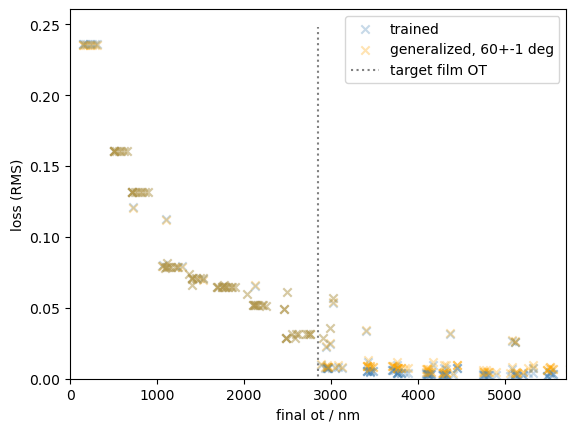

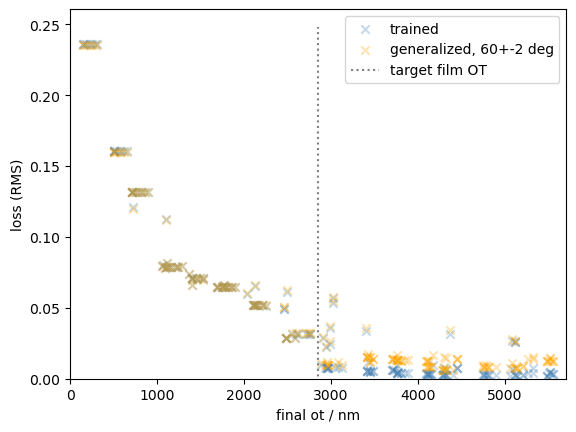

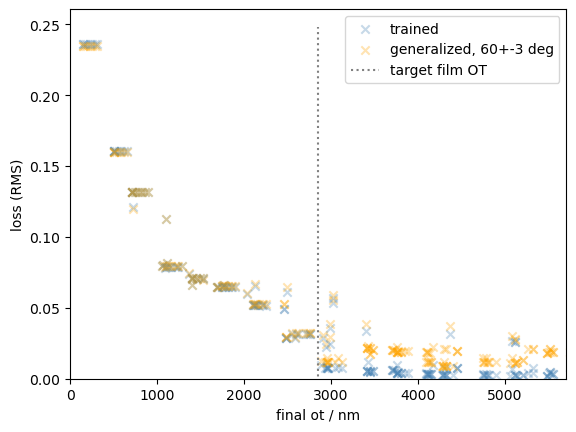

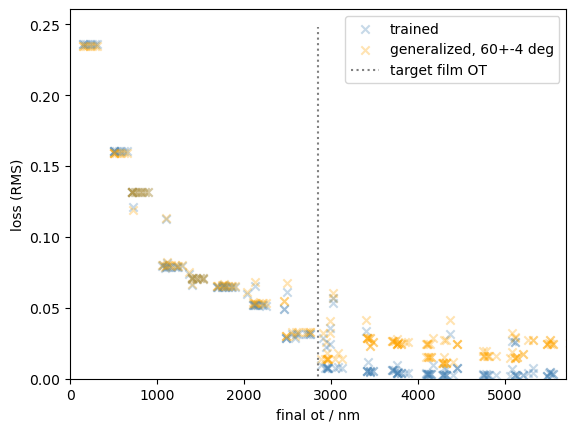

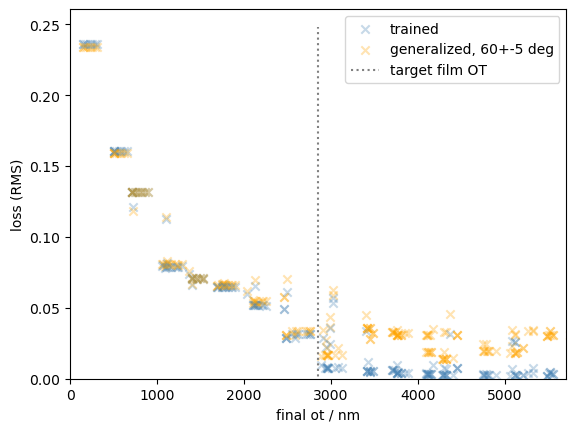

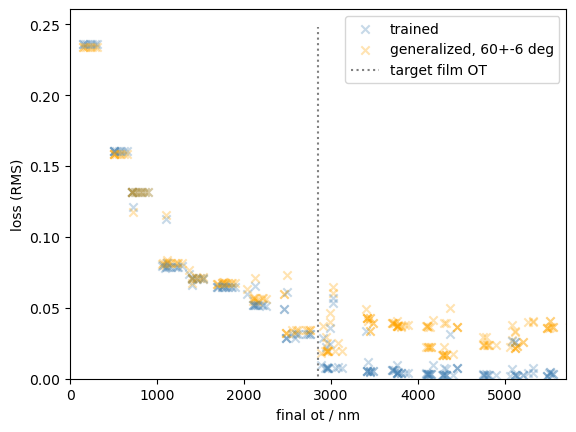

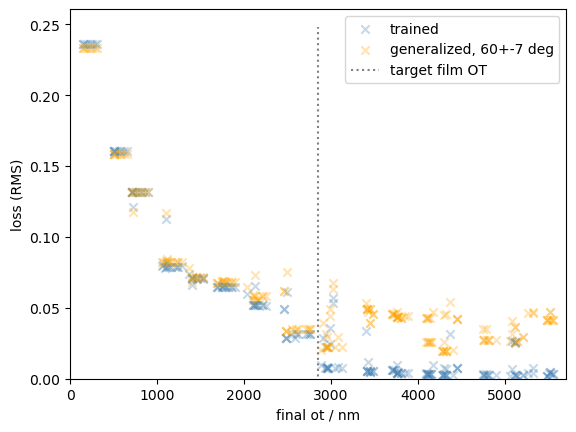

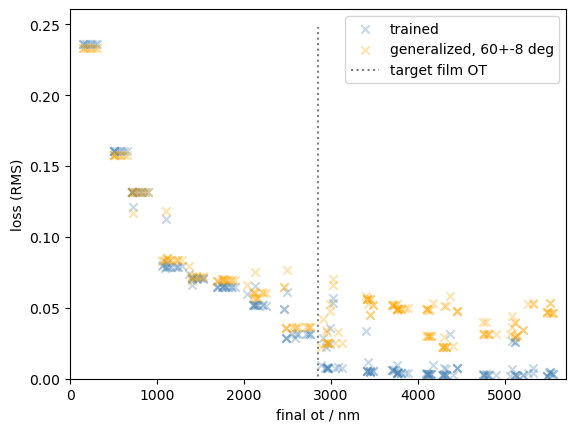

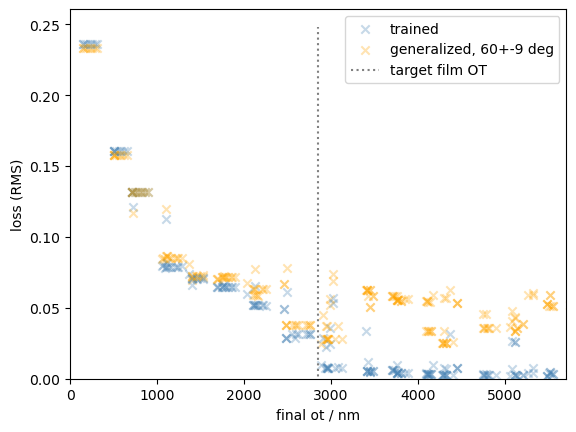

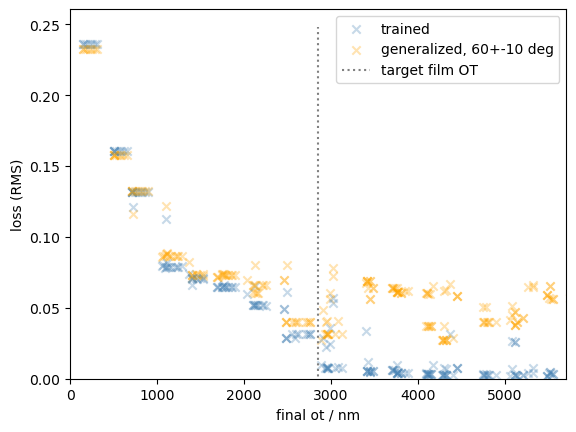

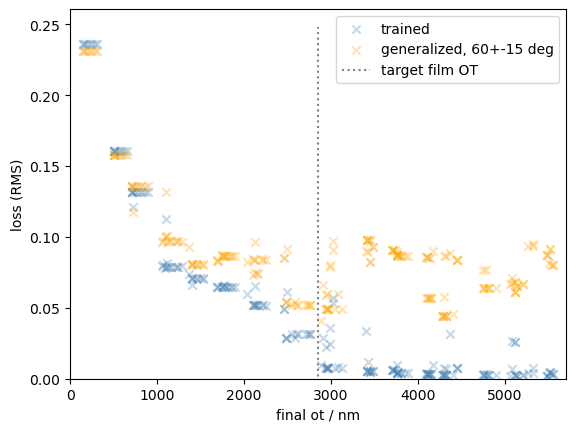

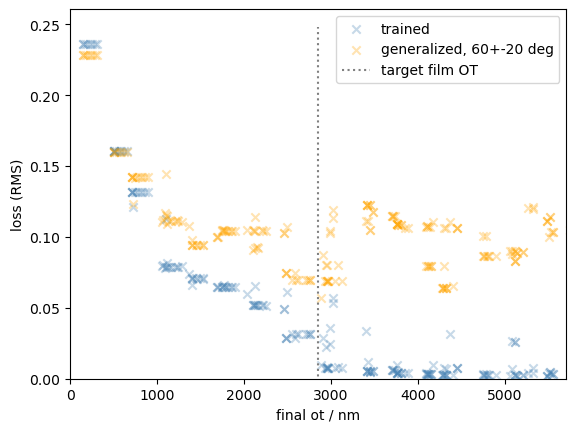

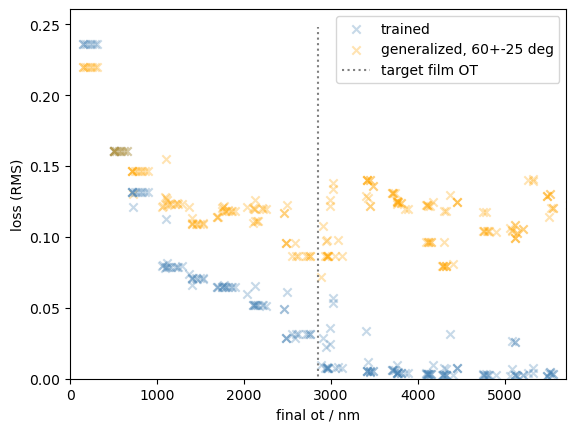

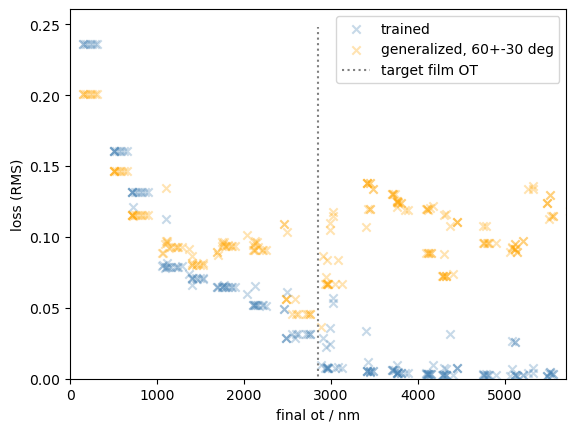

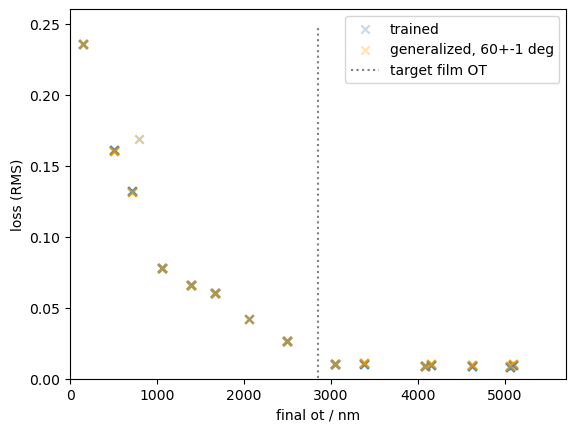

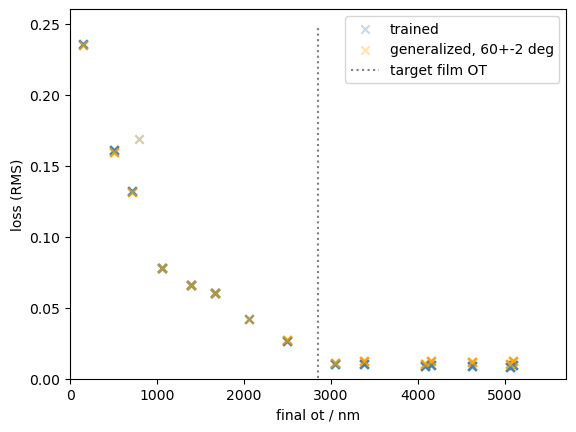

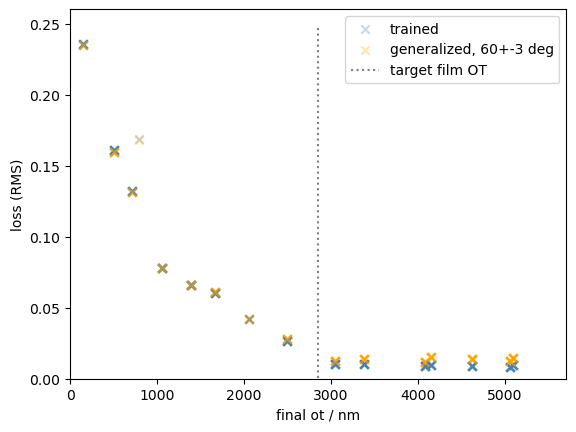

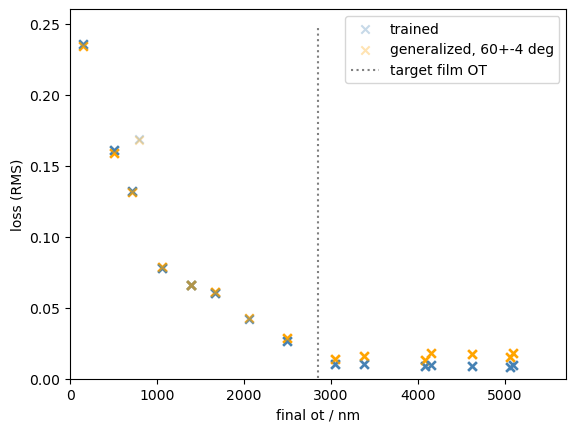

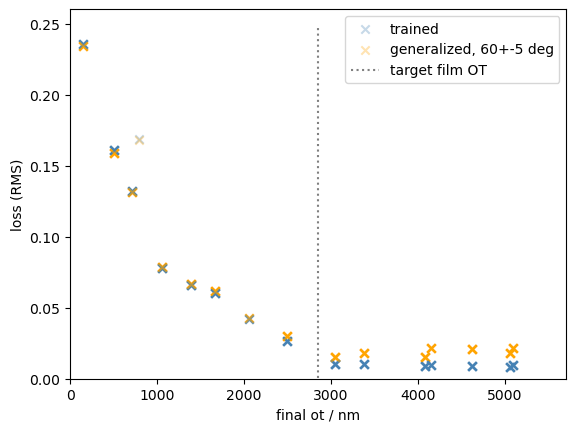

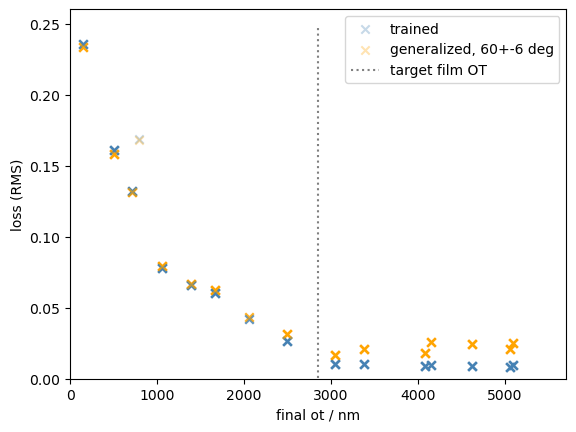

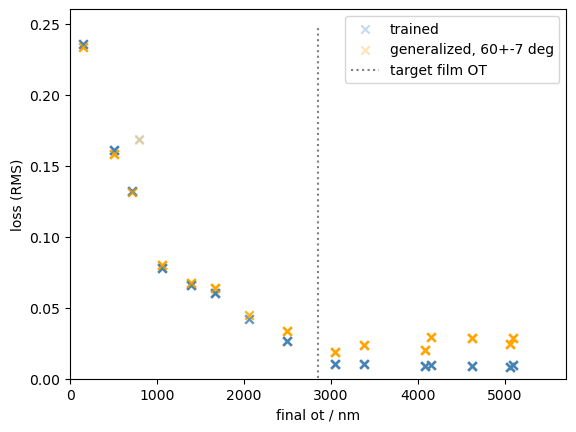

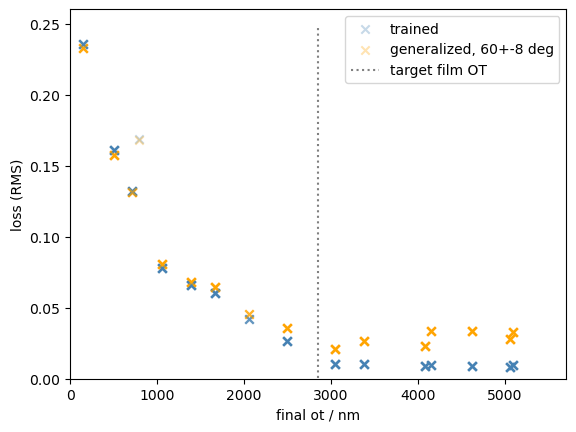

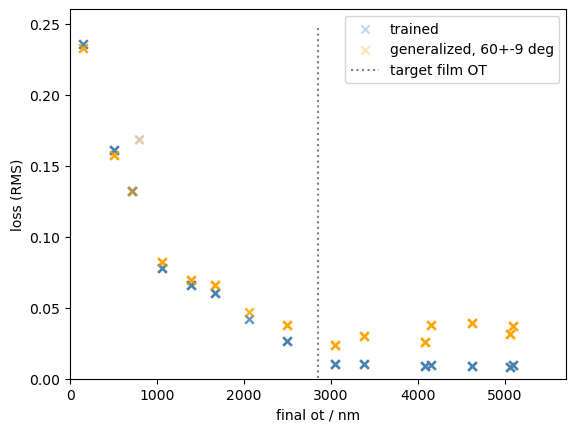

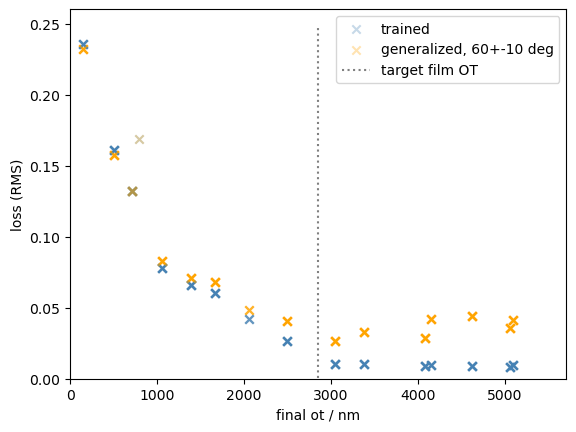

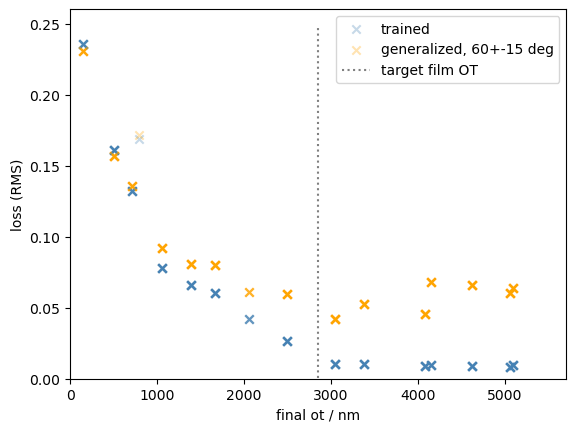

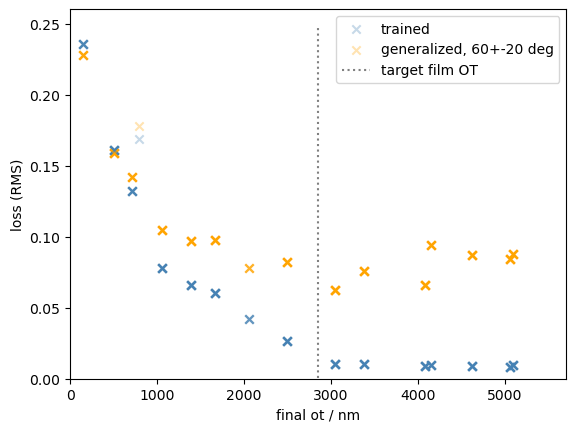

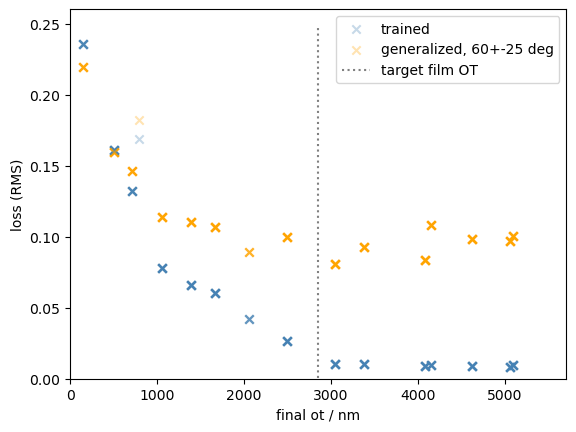

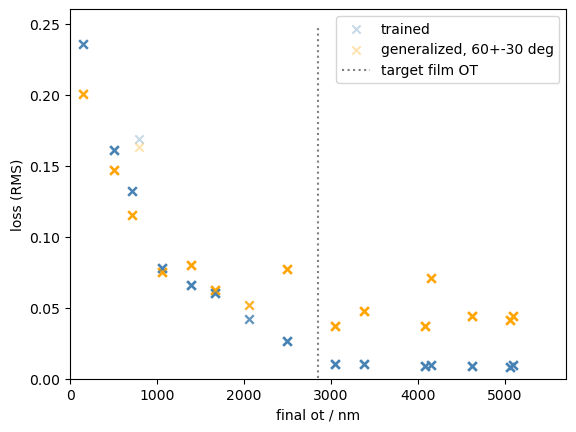

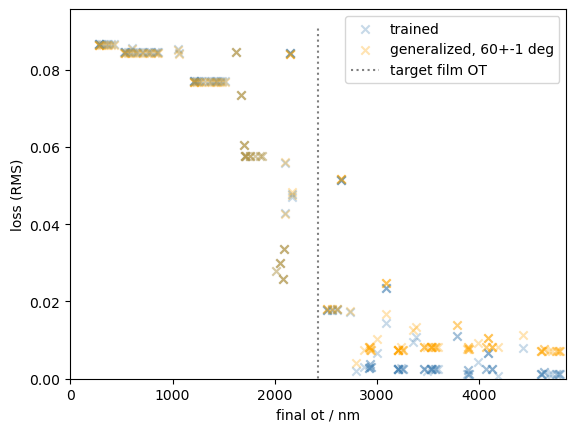

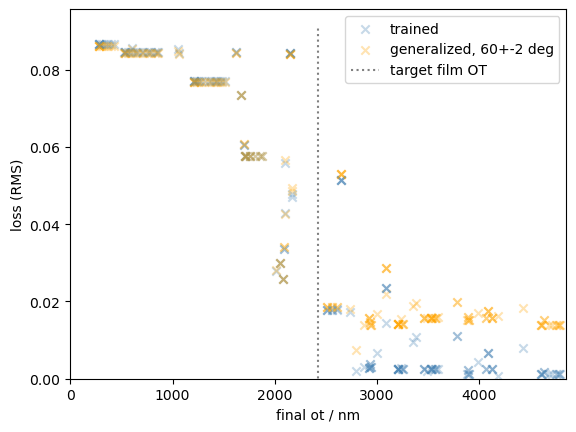

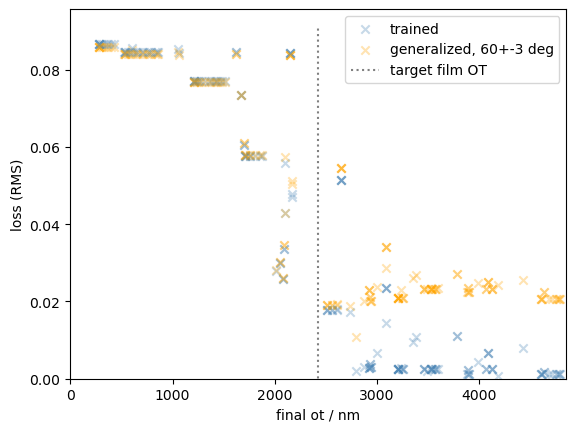

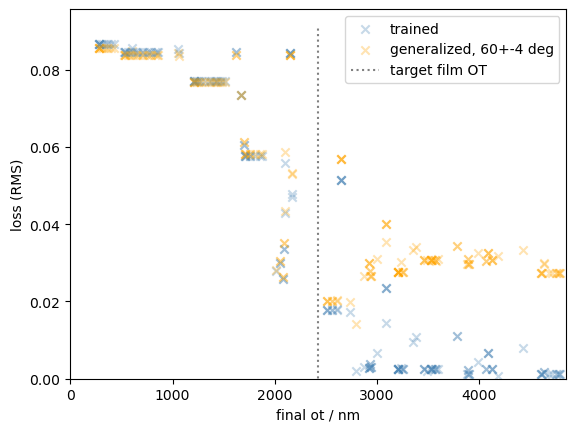

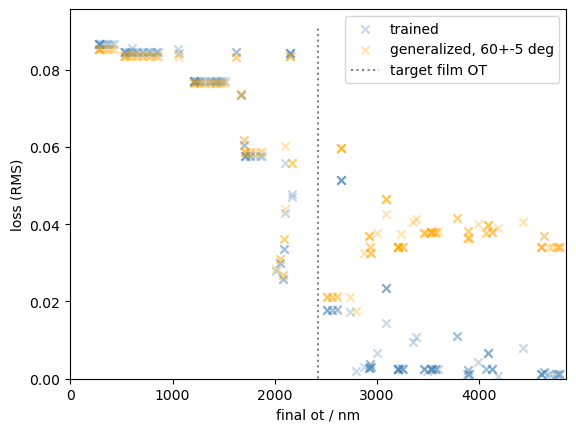

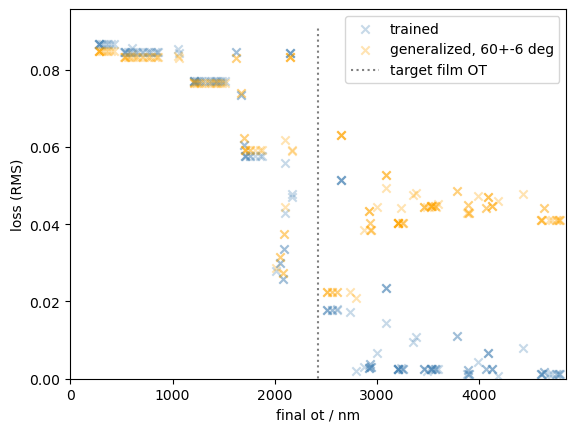

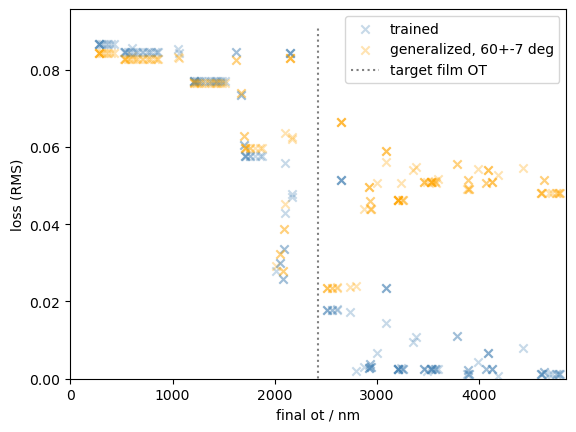

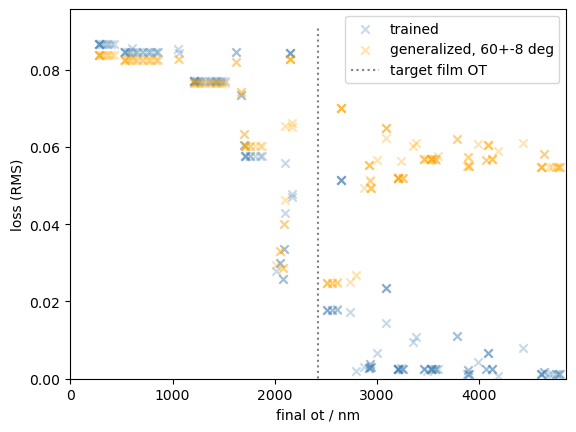

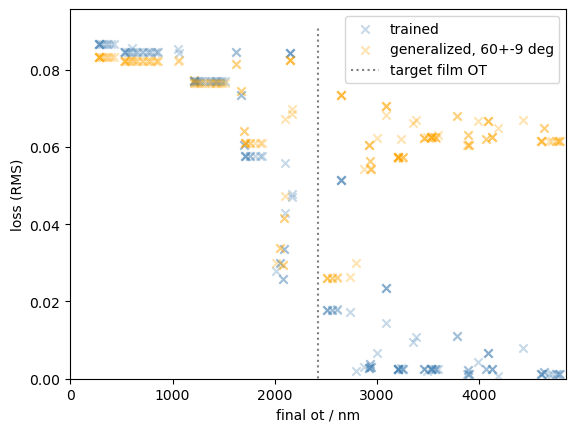

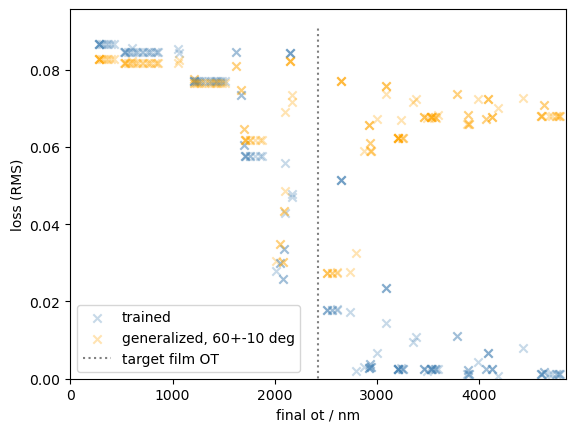

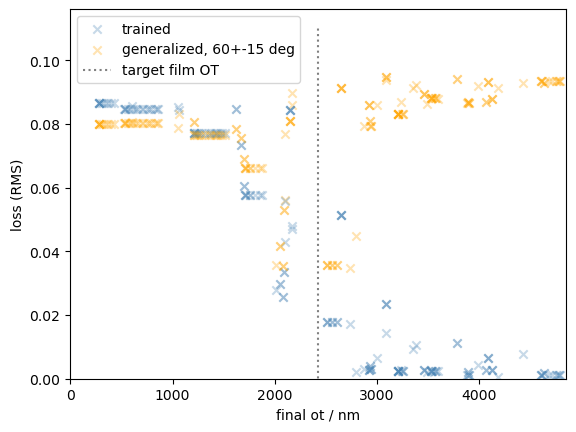

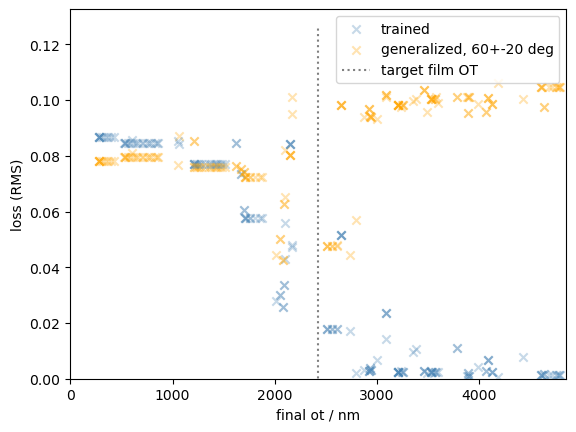

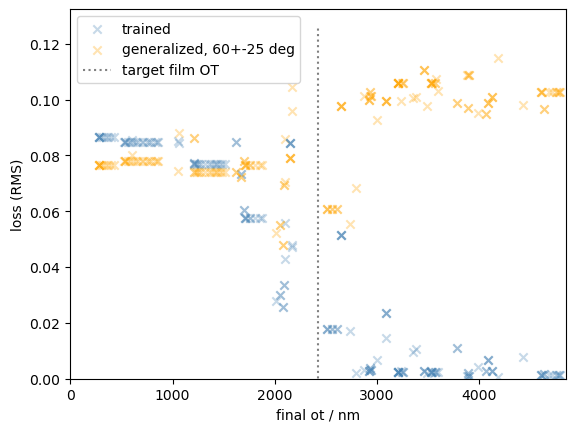

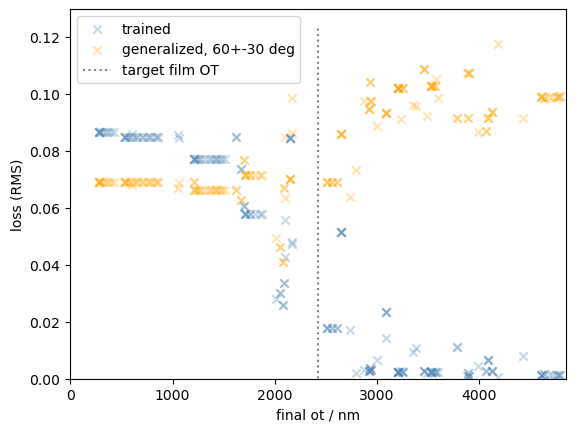

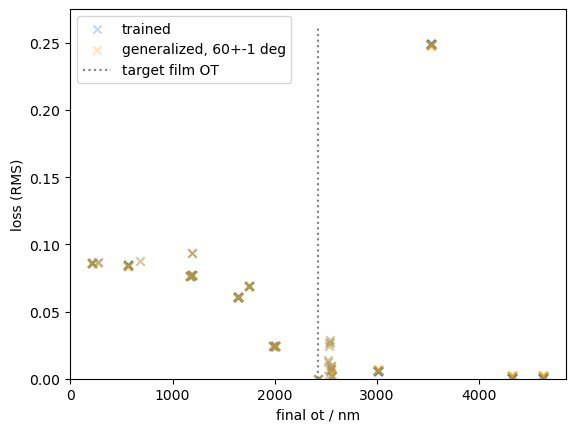

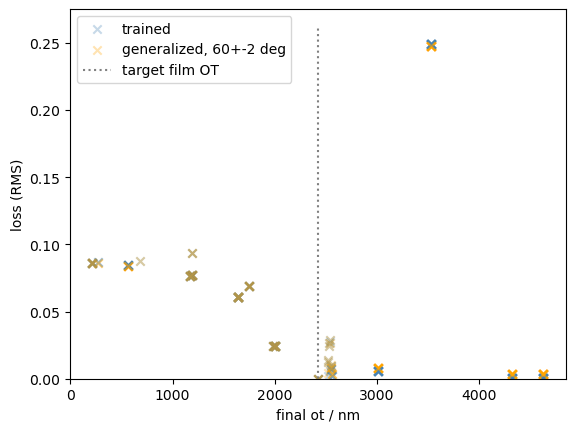

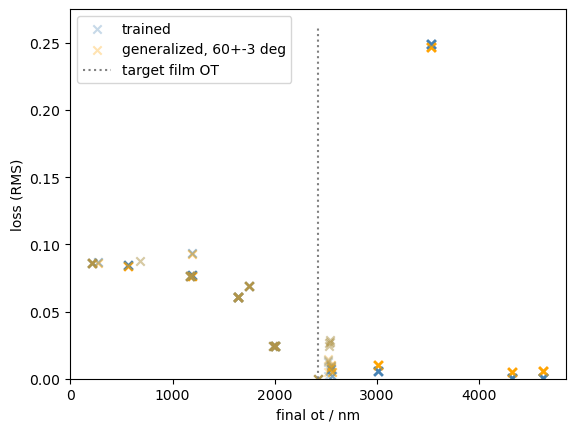

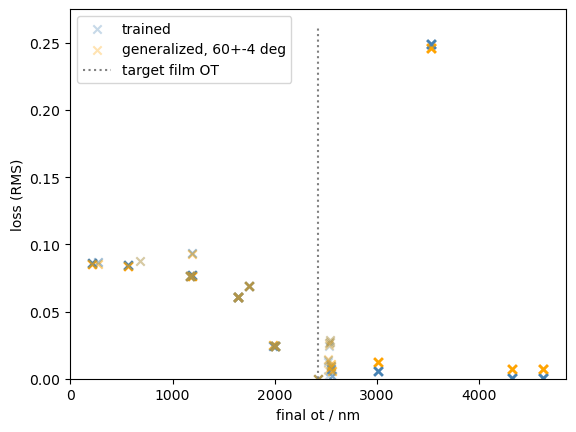

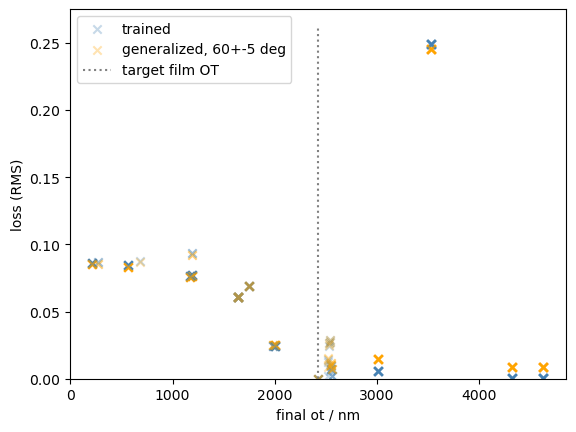

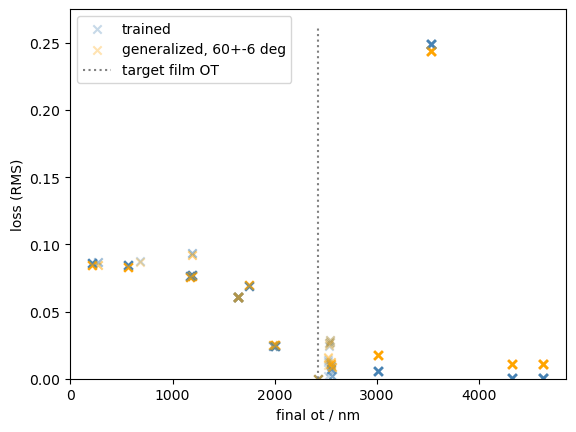

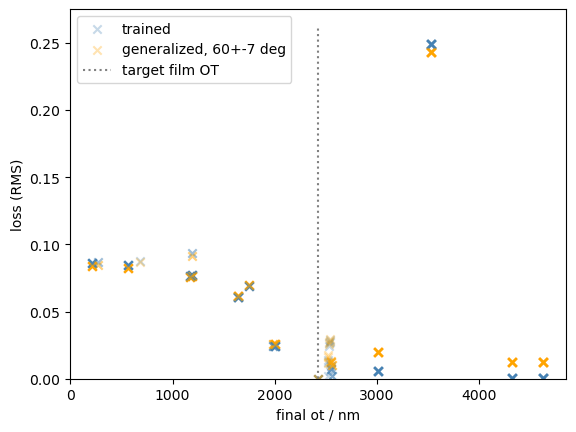

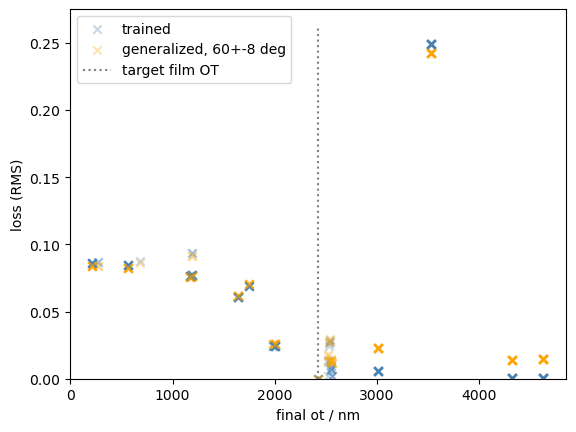

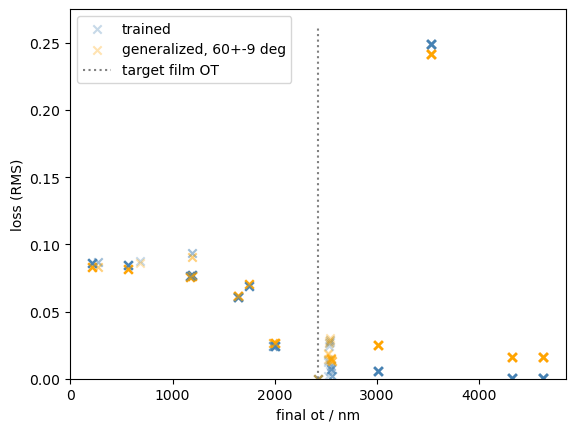

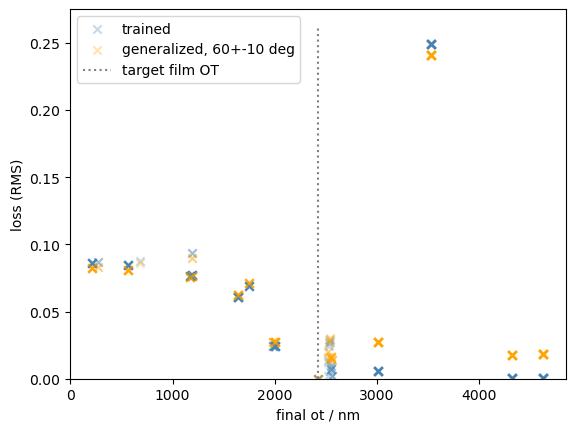

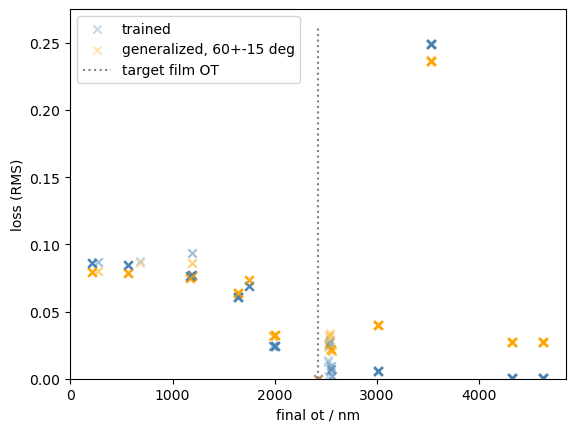

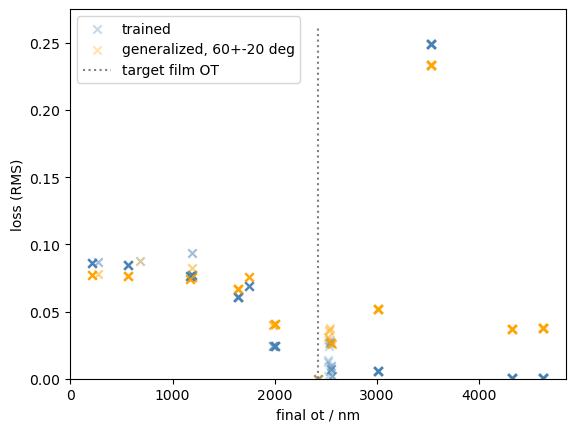

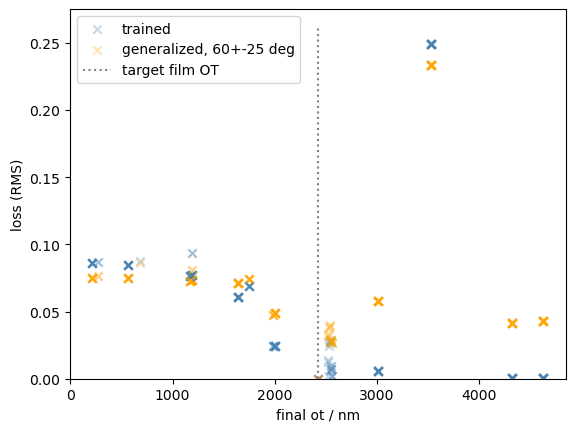

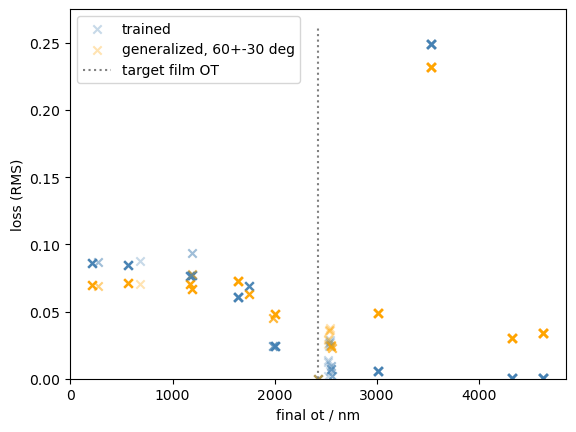

In [11]:


def plot_generalization(designs, file_dir):
    gen_angs_biases = list(range(1, 10)) + list(range(10, 35, 5))
    wl = 750.

    gen_number = len(gen_angs_biases)

    for i, gen_angs_bias in zip(range(gen_number), gen_angs_biases):
        gen_angs = [60. - gen_angs_bias, 60. + gen_angs_bias]

        def generalize(designs: list[DesignSimple]):
            gen_designs = []
            for design in designs:
                gen_design = copy.deepcopy(design)
                for inc_ang in gen_angs:
                    gen_design.target_film.add_spec_param(inc_ang, WLS)
                    gen_design.film.add_spec_param(inc_ang, WLS)
                gen_design.calculate_loss()
                gen_designs.append(gen_design)
            return gen_designs

        gen_designs = generalize(designs)

        def plot_final(design_list: list[DesignSimple], gen_designs_list: list[DesignSimple]): # bad variabe naming!
            fig, ax = plt.subplots(1, 1)
            for design, gen_design in zip(design_list, gen_designs_list):
                ax.scatter(design.get_current_ot(wl), design.loss, c='steelblue', marker='x', alpha=0.3)
                ax.scatter(gen_design.get_current_ot(wl), gen_design.loss, c='orange', marker='x', alpha=0.3)

            # scatter the first dot for the legend
            design, gen_design = designs[0], gen_designs[0]
            ax.scatter(design.get_current_ot(wl), design.loss, c='steelblue', marker='x', label='trained', alpha=0.3)
            ax.scatter(gen_design.get_current_ot(wl), gen_design.loss, c='orange', marker='x', label=f'generalized, 60+-{gen_angs_bias} deg', alpha=0.3)

            target_ot = design.get_target_ot(wl)
            ax.plot([target_ot, target_ot], ax.get_ylim(), label='target film OT', c='gray', ls=':')
            
            
            ax.legend()
            ax.set_xlabel('final ot / nm')
            ax.set_ylabel('loss (RMS)')
            ax.set_xlim(0, target_ot * 2)
            ax.set_ylim(0, None) # set lower bound of y to zero
            fig.savefig(file_dir+f"gen_60+-{gen_angs_bias}-wrt_final_ot.png", dpi=300)
           # plot one loss-init ot figure each iter

        def plot_init(design_list: list[DesignSimple], gen_designs_list: list[DesignSimple]): # bad variabe naming!
            fig, ax = plt.subplots(1, 1)
            for design, gen_design in zip(design_list, gen_designs_list):
                ax.scatter(design.get_init_ot(wl), design.loss, c='steelblue', marker='x', alpha=0.3)
                ax.scatter(gen_design.get_init_ot(wl), gen_design.loss, c='orange', marker='x', alpha=0.3)

            # scatter the first dot for the legend
            design, gen_design = designs[0], gen_designs[0]
            ax.scatter(design.get_init_ot(wl), design.loss, c='steelblue', marker='x', label='trained', alpha=0.3)
            ax.scatter(gen_design.get_init_ot(wl), gen_design.loss, c='orange', marker='x', label=f'generalized, 60+-{gen_angs_bias} deg', alpha=0.3)

            target_ot = design.get_target_ot(wl)
            ax.plot([target_ot, target_ot], ax.get_ylim(), label='target film OT', c='gray', ls=':')
            
            
            ax.legend()
            ax.set_xlabel('initial ot / nm')
            ax.set_ylabel('loss (RMS)')
            ax.set_xlim(0, target_ot * 2)
            ax.set_ylim(0, 0.4) # set lower bound of y to zero
            fig.savefig(file_dir+f"gen_60+-{gen_angs_bias}-wrt_initial_ot.png", dpi=300)
 
        # plot_init(designs, gen_designs)
        plot_final(designs, gen_designs)


plot_generalization(designs_SiO2_target30, save_fig_dir_SiO2_target_30layers)
plot_generalization(designs_TiO2_target30, save_fig_dir_TiO2_target_30layers)
plot_generalization(designs_SiO2_target4, save_fig_dir_SiO2_target_4layers) # time: about 4 mins
plot_generalization(designs_TiO2_target4, save_fig_dir_TiO2_target_4layers) # time: about 4 mins



c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\transforms.py:2860: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


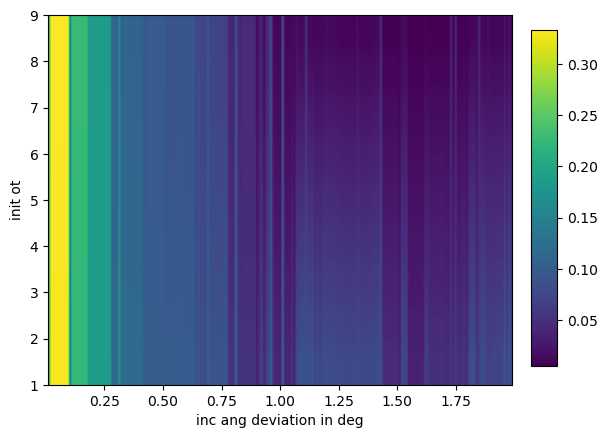

In [20]:
def plot_generalization_2d_imag(designs):
    gen_angs_biases = list(range(1, 10))
    gen_number = len(gen_angs_biases)
    gen_loss_arr = np.empty((gen_number, len(designs)))

    for i, gen_angs_bias in zip(range(gen_number), gen_angs_biases):
        gen_angs = [60. - gen_angs_bias, 60. + gen_angs_bias]

        def generalize(designs):
            gen_designs = []
            for design in designs:
                gen_design = copy.deepcopy(design)
                for inc_ang in gen_angs:
                    gen_design.target_film.add_spec_param(inc_ang, WLS)
                    gen_design.film.add_spec_param(inc_ang, WLS)
                gen_design.calculate_loss()
                gen_designs.append(gen_design)
            return gen_designs

        gen_designs = generalize(designs)

        for j in range(len(gen_designs)):
            gen_loss_arr[i, j] = gen_designs[j].loss

    fig, ax = plt.subplots(1, 1)
    target_ot = design.target_film.get_optical_thickness(wl)
    im = ax.imshow(gen_loss_arr,
            aspect='auto',
            extent=(
                designs[0].init_ot / target_ot,
                designs[-1].init_ot / target_ot,
                gen_angs_biases[0],
                gen_angs_biases[-1]
            )
        )
    ax.set_xlabel('inc ang deviation in deg')
    ax.set_ylabel('init ot')

    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
    fig.colorbar(im, cax=cbar_ax)